### Installing Required Libraries

In [1]:
pip install numpy pandas matplotlib kaggle seaborn opencv-python random2 dataframe_image statsmodels scikit-image scikit-learn keras-models zipfile36 Pillow joblib tensorflow keras

Note: you may need to restart the kernel to use updated packages.


### Importing Libraries

In [1]:
import numpy as np
from numpy import argmax
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
from collections import Counter
import dataframe_image as dfi

from statsmodels.tools import categorical
from skimage.filters import prewitt_h,prewitt_v
from sklearn.neighbors import KNeighborsClassifier
from keras.models import load_model

import zipfile
from PIL import Image
from sklearn.metrics import plot_confusion_matrix, multilabel_confusion_matrix, roc_auc_score,accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import time


### Setting Variables and Creating Functions

In [2]:
FishCategories = ["Black Sea Sprat", "Gilt-Head Bream", "Hourse Mackerel", "Red Mullet", 
                  "Red Sea Bream", "Sea Bass", "Shrimp","Striped Red Mullet", "Trout"]
ColorLabels = ['Red','Orange','Brown','Tan','Blue', 'LightBlue','Gray', 'White','Black']
np.array(ColorLabels)
ColorValues = [[200,75,75], [200,125,75], [151,122,83], [217,171,118],[75,75,200],[165,165,165],[125,125,125],[235,235,235],[20,20,20]]
ColorValuesMap = [[200,75,75], [200,125,75], [151,122,83], [217,171,118],[20,20,20],[20,20,20],[20,20,20],[235,235,235],[20,20,20]]


######################## GET IMAGES FROM KAGGLE AND INTO PYTHON ########################
#This function downloads the dataset from Kaggle.com and stores it in the working directory
def DownloadDataset():
    os.environ['KAGGLE_USERNAME'] = 'capstoneddg'
    os.environ['KAGGLE_KEY'] = '43717164337825aa55a1ba0dc8c4b0f2'
    from kaggle.api.kaggle_api_extended import KaggleApi
    api = KaggleApi()
    print("Authenticating API")
    api.authenticate()
    print("Downloading Dataset to Working Directory")
    print("This could take a few minutes.")
    api.dataset_download_file("crowww/a-large-scale-fish-dataset", file_name = '')
    print("Download Complete")

#This function runs through the zip folder and extracts out the images   
def GetData ():
    RawColor = []
    RawBW = []
    ImageLabel = []
    FishPosition = []
    counter = 0
    print("Getting Images")
    with zipfile.ZipFile(os.path.join(os.getcwd(),'archive.zip'), 'r') as zipref:
        for imagepath in zipref.namelist():
            if (imagepath.__contains__('GT')):
                pass
            elif (imagepath.__contains__('NA_Fish_Dataset')):
                pass
            elif (imagepath.__contains__('png')): #Text was img
                for FishType in FishCategories:
                    if imagepath.__contains__(FishType):
                        fishcategory = FishType
                        FishNumber = FishCategories.index(FishType)
                OriginalImage = Image.open(zipref.open(imagepath))
                OriginalImagePixelBGR = np.array(OriginalImage)
                ImageLabel.append(fishcategory)
                FishPosition.append(FishNumber)
                #RawBW.append(cv2.cvtColor(OriginalImagePixelBGR, cv2.COLOR_BGR2GRAY))
                RawColor.append(OriginalImagePixelBGR)    
                if (counter + 1) % 1500==0:
                    print("Retrieved",counter + 1,"Images of 9000")
                elif counter == 0:
                    print("Retrieved",counter,"Images of 9000")
                counter = counter + 1
    return np.array(RawColor), np.array(ImageLabel), np.array(FishPosition)


######################## FOR DATA EXPLORATION ########################
# Shapes the image approperately for modeling
def GetFlattenedImageForClassification(Img, w, h):
    return np.reshape(Img,(w*h,3))


######################## COMMON FUNCTIONS ########################
#simple function for resizing images
def Resize(image_,w,h):
    newsize = (w, h)
    return cv2.resize(image_, dsize = newsize)

# This function gets a random sampling between 1 and 9000. 
def RandomSample(SampleAmount):
    ListRange = range(9000)
    Sample = []
    for i in range(SampleAmount):
        Sample.append(random.choice(ListRange))
    return Sample

#Saves models to the working directory
def SaveFile(Model,FileName):
    Model.save(FileName) 
    print("Saved model to disk")
 
 #Opens a model from the working directory
def OpenFile(FileName):
    return load_model(FileName)

def AddColorDistortionToImage(ImageNum,pct):
    x,y,d = ResizeImages[ImageNum].shape
    InterCount = round(x*y*pct/100)
    for i in range(InterCount):
        RandomNumOfColors = random.randint(1,3)
        RandPos_x = random.randint(0,x-1)
        RandPos_y = random.randint(0,y-1)
        for j in range(RandomNumOfColors):
            RandPixVal = random.randint(0, 255)
            RandColorLvl = random.randint(0,2)
            ResizeImages[ImageNum][RandPos_x,RandPos_y,RandColorLvl] = RandPixVal
    return

######################## MODELS ########################

#Using the colors below each pixel in every image is classified as one of those colors. From there
#the pixels that are black and blue  are removed from the image and the rest of the colors are 
#counted and totaled so they can be used in the KNN, SVM, and RF

def ClassifyPixelColor(width, height, samplesize):
    ColorLabels = ['Red','Orange','Brown','Tan','Blue', 'LightBlue','Gray', 'White','Black']
    ColorValues = [[200,75,75], [200,125,75], [151,122,83], [217,171,118],[75,75,200],[165,165,165],[125,125,125],[235,235,235],[20,20,20]]
    ColorValuesMap = [[200,75,75], [200,125,75], [151,122,83], [217,171,118],[20,20,20],[20,20,20],[20,20,20],[235,235,235],[20,20,20]]
    w = width
    h = height
    zeros = np.zeros(9, dtype=int)
    dim = (w,h)
    totals = []
    ModifiedImages = []
    ModifiedImagesWoMap = []
    OriginalResizedImages = []
    ClLabels = []
    sampleset = ResizeImages[RandomSample(samplesize)]

    for i in range(samplesize):
        ClassifiedLabels = []
        Reshaped = np.reshape(sampleset[i],(w*h,3))
        ReshapedWOMap = Reshaped
        ColorLabels = np.array(ColorLabels)
        zeros = np.zeros(9, dtype=int)
        for p in range(w*h):
            Dif = np.array(np.sum(abs(Reshaped[p]-ColorValues), axis = 1))
            Current = 1000
            for c in range(len(ColorLabels)):
                if Dif[c] < Current:
                    ColorWithMap = ColorValuesMap[c]
                    ColorWithoutMap = ColorValues[c]
                    ColorLabelsMap = ColorLabels[c] 
                    Current = Dif[c]
            zeros[ColorValuesMap.index(ColorWithMap)] = zeros[ColorValuesMap.index(ColorWithMap)] + 1
            Reshaped[p] = ColorWithMap
            ReshapedWOMap[p] = ColorWithoutMap
            ClassifiedLabels.append(ColorLabelsMap)
        totals.append(zeros)
        ModifiedImages.append(np.reshape(Reshaped,(h,w,3)))
        ModifiedImagesWoMap.append(np.reshape(ReshapedWOMap, (h,w,3)))
        OriginalResizedImages.append(sampleset[i])
        ClLabels.append([ClassifiedLabels])
    totals = np.array(totals)
    totals = pd.DataFrame(totals)
    totals.columns = ["Reds", "Oranges", "Browns", "Tans", "Blues", "LightBlues", "Grays", "Whites", "Blacks"]
    totalsAdj = totals[["Reds", "Oranges", "Browns", "Tans", "Grays","Whites"]]
    return np.array(OriginalResizedImages), np.array(ModifiedImagesWoMap), np.array(ModifiedImages),np.array(ClLabels) ,totals

def TrainPixelClassificationModel():
    X = []
    Y = []
    wl,hl,dl = ClassifiedLabels.shape
    for i in range(len(NewImage)):
        W,H,D = NewImage[i].shape 
        X.append(np.reshape(OriginalImage[i],(W*H,D)))
        Y.append(ClassifiedLabels[i])
    #print("Labels Obtained")
    im_count, pix_count, rgb = np.array(X).shape  
    x = pd.DataFrame(np.reshape(X,(im_count*pix_count,3)))
    y = np.reshape(Y,(wl*hl*dl))
   # print("Training Classifier")
    PixelClassifier = RandomForestClassifier(n_estimators=1, 
                            min_samples_split = 5, 
                            min_samples_leaf=2,
                            max_features = 'sqrt',
                            bootstrap = False)
    PixelClassifierFitted = PixelClassifier.fit(x, y)
    print("Score: ",PixelClassifierFitted.score(x,y))
    joblib.dump(PixelClassifierFitted, "NonCNNModels/PixelClassifierFitted.joblib")
    return

# builds the fitted CNN model
def BuildCNN(ResizeH, ResizeW, BatchSize, Epochs, X, Y,ArrayDepth):
    #GET IMAGE LABELS
    encoder = OneHotEncoder(sparse=False)
    Y_VALUE = pd.DataFrame(Y)
    Y_VALUE = Y_VALUE.astype('category')
    Y_VALUE_CAT = pd.DataFrame(encoder.fit_transform(Y_VALUE)) 
    
    #RESIZES THE IMAGES
    ResizedImages = []
    for i in range(len(X)):
        R_images = X[i]
        ResizedImages.append(R_images)
    ResizedImages = np.array(ResizedImages)/255
    
    #TRAIN TEST SPLIT
    X_train, X_test, y_train, y_test = train_test_split(ResizedImages, Y_VALUE_CAT, test_size=0.33, random_state=42)
    y_test_array = argmax(np.array(y_test), axis=-1).astype('int')
    y_train_array = argmax(np.array(y_train), axis=-1).astype('int')
    
    #CONSTRUCT LAYERS MODEL
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(ResizeH, ResizeW, ArrayDepth)))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size = (3, 3)))

    #model.add(Conv2D(64, (3, 3), activation='relu'))
    #model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())

    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(9, activation = "softmax"))
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    #TRAIN MODEL
    model.fit(X_train, y_train, batch_size = BatchSize, epochs = Epochs)
    
    return model, X_test, y_test_array, X_train, y_train_array



######################## RESULTS FUNCTIONS ########################
# Converts image into preprocessed image
def GetPixelClassifiedImage (Img,w,h,Fitted):
    Image = np.reshape(Img,(w*h,3))
    PredictLabels = Fitted.predict(Image)
    ImgW = PredictLabels.shape
    Color = []
    for p in range(len(PredictLabels)):
        Color.append(ColorValuesMap[(ColorLabels.index(PredictLabels[p]))])
    plt.imshow(np.reshape(Color,(w,h,3)))
    plt.show()
    return


# builds a multiclass confusion matrix
def ConfusionMatrix(yt, yh,FileName): 
    CM = np.zeros((len(FishCategories), len(FishCategories)))
    for i in range(len(yt)):
        AP = yt[i]
        PP = yh[i]
        CM[AP][PP] = CM[AP][PP] + 1
    s = sns.heatmap(CM, 
                linewidth=0.5,
                square=True, 
                cmap='viridis',
                annot=True,
                fmt= '.0f',
                xticklabels=FishCategories, 
                yticklabels=FishCategories)
    s.set(xlabel='Predicted', ylabel='Actual')
    results_path = str(FileName)
    plt.savefig('GUI Images/'+results_path,bbox_inches='tight', dpi=65)
    return CM, plt.show()

def GetRocGraphValues(CM):
    CM = CM[0]
    for thresh in np.linspace(0, 1, 100):
        TP = 0
        FP = 0
        for col in range(9):
            TP = TP + CM[col][col]
            for row in range(9):
                if row > col:
                    FP = FP + CM[row][col]
        tpr = TP/(TP+FP)
        fpr = FP/(FP+TP)
    return tpr, fpr 

### Getting Images

In [3]:
#If the zip file of the images is found in the working directory, then it will start pulling it into 
#python otherwise it will download the dataset and pull it into memory

if os.path.exists(os.path.join(os.getcwd (),'archive.zip')):
    pass
else:
    DownloadDataset()
ColorImages, ImageLabels, FishPosition = GetData() 

Getting Images
Retrieved 0 Images of 9000
Retrieved 1500 Images of 9000
Retrieved 3000 Images of 9000
Retrieved 4500 Images of 9000
Retrieved 6000 Images of 9000
Retrieved 7500 Images of 9000
Retrieved 9000 Images of 9000


### Modifying the images to make them more unique

In [4]:
ResizeImages = []
for i in range(9000):
    img_ = ColorImages[i]
    img_ = cv2.blur(img_,(random.randint(1,3),random.randint(1,3)))
    img_ = cv2.resize(img_,(50,50))
    ResizeImages.append(img_)  
    if i % 1500 == 0:
        print(i, "images blurred and resized.")
ResizeImages = np.array(ResizeImages)

0 images blurred and resized.
1500 images blurred and resized.
3000 images blurred and resized.
4500 images blurred and resized.
6000 images blurred and resized.
7500 images blurred and resized.


### Pre-Processing and Model Training for CNN

In [5]:
TimeToTrain = []

start = time.time()
CNNFitted,CNNX_test, CNNY_test_label,CNNX_train,CNNY_train_label = BuildCNN(50,50,25,5,ResizeImages,ImageLabels,3)
end = time.time()
TimeToTrain.append(["CNN","Preprocessing and Training",end - start])
SaveFile(CNNFitted,'CNNModel/'+'CNNModel.h5')


Epoch 1/5
242/242 [==============================] - 21s 83ms/step - loss: 1.1434 - accuracy: 0.5828
Epoch 2/5
242/242 [==============================] - 22s 91ms/step - loss: 0.3993 - accuracy: 0.8615
Epoch 3/5
242/242 [==============================] - 24s 101ms/step - loss: 0.1700 - accuracy: 0.9453
Epoch 4/5
242/242 [==============================] - 26s 105ms/step - loss: 0.0936 - accuracy: 0.9697
Epoch 5/5
242/242 [==============================] - 23s 93ms/step - loss: 0.0646 - accuracy: 0.9791
Saved model to disk


### Getting CNN Results

CNN
0.9592592592592593


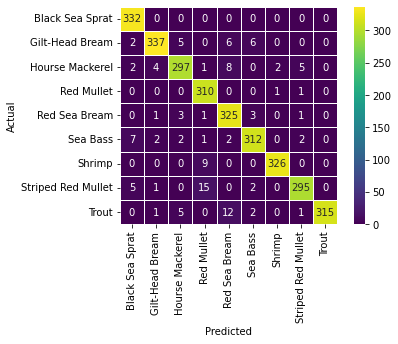

0.9991148456611894

In [6]:
# Saving CNN Model
CNNFitted = OpenFile('CNNModel/CNNModel.h5')
start = time.time()
PredictedPercent = CNNFitted.predict(CNNX_test)
end = time.time()
TimeToTrain.append(["CNN","Predicting",end - start])
CNNyhat = argmax(PredictedPercent, axis=-1).astype('int')
print("CNN")

PredictedPercentTrain = CNNFitted.predict(CNNX_train)
CNNyhatTrain = argmax(PredictedPercentTrain, axis=-1).astype('int')

CNNTTrainingAccuracy = accuracy_score(CNNyhatTrain,CNNY_train_label)
CNNTTestingAccuracy = accuracy_score(CNNyhat,CNNY_test_label)
print(accuracy_score(CNNyhat,CNNY_test_label))
CNNCM=ConfusionMatrix(CNNY_test_label, CNNyhat,"ConfusionMatrix_CNN.png")
CNN_ROC_Score = roc_auc_score(CNNY_test_label, PredictedPercent, multi_class='ovr')
CNN_ROC_Score

### Pre-Processing for KNN, SVM, and Random Forest

In [7]:
OriginalImage, NewImageWoMapping, NewImage, ClassifiedLabels ,Counts = ClassifyPixelColor(50,50,100) 
TrainPixelClassificationModel()

TotalCounts = []
Fitted = joblib.load("NonCNNModels\PixelClassifierFitted.joblib")
k = 0
# Resizing and flattening images
StartPreProcessing = time.time()
starttime = time.time()
for i in ResizeImages:
    if k % 1500 == 0: print("Processed: ", k)
    Image = GetFlattenedImageForClassification(i,50,50)
    PredictedLabels = Fitted.predict(Image)
 
    counter = Counter(PredictedLabels) 
    result = [(key, counter[key]) for key in counter]
    zeros = np.zeros(9, dtype=int)
    for i in result:
        j = ColorLabels.index(i[0])
        zeros[j] = i[1]
    TotalCounts.append(zeros)
    k = k + 1
EndPreProcessing = time.time()

Score:  1.0
Processed:  0
Processed:  1500
Processed:  3000
Processed:  4500
Processed:  6000
Processed:  7500


### KNN, SVM, and Random Forest Training and Model Results

KNN
0.9272727272727272


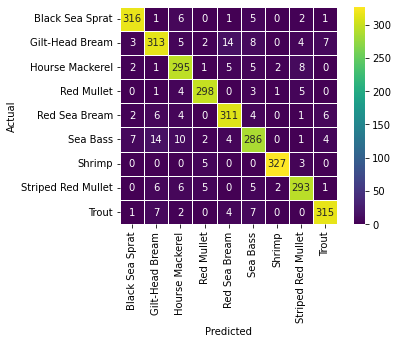

SVM
0.8754208754208754


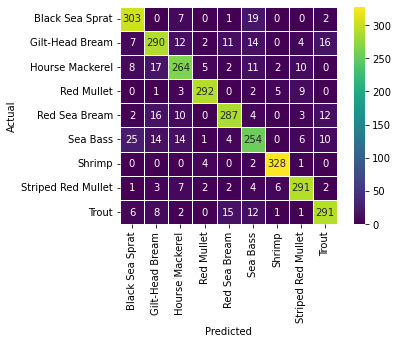

Random Forest
0.9144781144781144


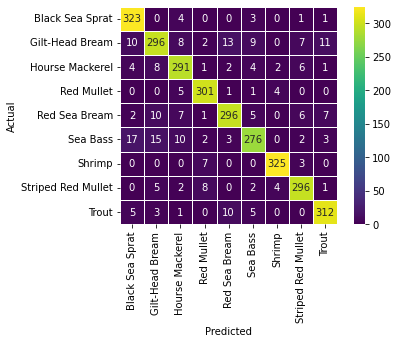

In [8]:
#Getting the Y labels for the KNN, SVM, and Random Forest models
TotalCounts = pd.DataFrame(TotalCounts)
TotalCounts.columns = ["Reds", "Oranges", "Browns", "Tans", "Blues", "LightBlues", "Grays", "Whites", "Blacks"]
n = 0
index = []
for j in range(9):
    for i in range(1000):
         index.append(n)
    n = n+1
ColorDim = [index]
ColorDimDt = pd.DataFrame(np.transpose(ColorDim))

X_train, X_test, y_train, y_test = train_test_split(TotalCounts[["Reds", "Oranges", "Browns", "Tans","Whites"]][:],
                                                    ColorDimDt[0], test_size=0.33, random_state=42)
y_test = np.array(y_test).astype('int')

#KNN
StartTrainingKNN = time.time()
KNN = KNeighborsClassifier(n_neighbors=1)
KNNFitted = KNN.fit(X_train, y_train)
EndTrainingKNN = time.time()
TimeToTrain.append(["KNN","Preprocessing and Training",
                    (EndPreProcessing - StartPreProcessing) + 
                    (EndTrainingKNN-StartTrainingKNN)])
joblib.dump(KNNFitted, "NonCNNModels\KNNModel.joblib")
print("KNN")
knnTrainingAccuracy = KNNFitted.score(X_train,y_train)
KnnTestedAccuracy = KNNFitted.score(X_test,y_test)
print(KNNFitted.score(X_test,y_test))


start = time.time()
KNNYhat = np.array(KNNFitted.predict(X_test)).astype('int')
end = time.time()
TimeToTrain.append(["KNN","Predicting",(end - start)])
KNNCM = ConfusionMatrix(y_test, KNNYhat,"ConfusionMatrix_KNN.png")
KNN_ROC_Score = roc_auc_score(y_test, KNNFitted.predict_proba(X_test), multi_class='ovr')


#SVM
SVM = SVC(kernel = 'rbf' ,C=10000, decision_function_shape='ovr',probability = True)
StartTrainingSVM = time.time()
SVMFitted = SVM.fit(X_train, y_train)
EndTrainingSVM = time.time()
TimeToTrain.append(["SVM","Preprocessing and Training",
                    (EndPreProcessing - StartPreProcessing)+
                    (EndTrainingSVM-StartTrainingSVM)])
joblib.dump(SVMFitted, "NonCNNModels\SVMModel.joblib")
print("SVM")
SVMTrainingAccuracy = SVMFitted.score(X_train,y_train)
SVMTestedAccuracy = SVMFitted.score(X_test,y_test)
print(SVMFitted.score(X_test,y_test))

start = time.time()
SVMYhat = np.array(SVMFitted.predict(X_test)).astype('int')
end = time.time()
TimeToTrain.append(["SVM","Predicting",(end - start)])
SVMCM = ConfusionMatrix(y_test, SVMYhat,"ConfusionMatrix_SVM.png")
SVM_ROC_Score = roc_auc_score(y_test, SVMFitted.predict_proba(X_test), multi_class='ovr')


#Random Forest
RF = RandomForestClassifier(n_estimators=150, 
                            min_samples_split = 5, 
                            min_samples_leaf=2,
                            max_features = 'sqrt',
                            bootstrap = True)
StartTrainingRF = time.time()
RFFitted = RF.fit(X_train, y_train)
EndTrainingRF = time.time()
TimeToTrain.append(["RF","Preprocessing and Training",
                    (EndPreProcessing - StartPreProcessing)+
                    (EndTrainingRF-StartTrainingRF)])
joblib.dump(RFFitted, "NonCNNModels\RFModel.joblib")
print("Random Forest")
RFTrainingAccuracy = RFFitted.score(X_train,y_train)
RFTestedAccuracy = RFFitted.score(X_test,y_test)
print(RFFitted.score(X_test,y_test))

start = time.time()
RFYhat = np.array(RFFitted.predict(X_test)).astype('int')
end = time.time()
TimeToTrain.append(["RF","Predicting",(end - start)])
RFCM = ConfusionMatrix(y_test, RFYhat,"ConfusionMatrix_RF.png")
RF_ROC_Score = roc_auc_score(y_test, RFFitted.predict_proba(X_test), multi_class='ovr')



### Build ROC Plot

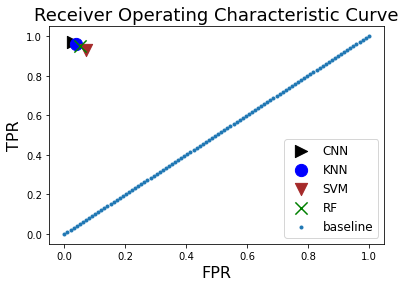

In [9]:
fig, ax = plt.subplots()
CNNtpr,CNNfpr = GetRocGraphValues(CNNCM)
KNNtpr,KNNfpr = GetRocGraphValues(KNNCM)
SVMtpr,SVMfpr = GetRocGraphValues(SVMCM)
RFtpr,RFfpr = GetRocGraphValues(RFCM)
ax.scatter(CNNfpr, CNNtpr, color = 'black',marker = '>', s = 150,label = 'CNN')
ax.scatter(KNNfpr, KNNtpr, color = 'blue',marker = 'o', s = 150,label = 'KNN')
ax.scatter(SVMfpr, SVMtpr, color = 'brown',marker = 'v', s = 150,label = 'SVM')
ax.scatter(RFfpr, RFtpr, color = 'green',marker = 'x', s = 150,label = 'RF')
ax.scatter(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         marker = '.')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12)
rp = str("GUI Images\ROC-AUC.png")
plt.savefig(rp, dpi = 63);    

### Building Results Table

In [10]:
TimeDataFrame = pd.DataFrame(np.array(TimeToTrain))
TimeDataFrame.columns = ["Model","TimeType","Time (Seconds)"]
Predicting = TimeDataFrame[TimeDataFrame["TimeType"]=='Predicting']["Time (Seconds)"]
Training = TimeDataFrame[TimeDataFrame["TimeType"]=='Preprocessing and Training']["Time (Seconds)"]
TrainingAccuracy = [CNNTTrainingAccuracy, knnTrainingAccuracy, SVMTrainingAccuracy, RFTrainingAccuracy]
TestingAccuracy = [CNNTTestingAccuracy, KnnTestedAccuracy, SVMTestedAccuracy, RFTestedAccuracy]
ROC = [CNN_ROC_Score, KNN_ROC_Score,SVM_ROC_Score, RF_ROC_Score]
TimeDataFrameClean = pd.DataFrame(np.transpose(np.array([['CNN',"KNN","SVM","RF"],TrainingAccuracy, TestingAccuracy, Training,Predicting, ROC])))
TimeDataFrameClean.columns = ["Model","Training Accuracy","Testing Accuracy","Preprocessing and Training (Sec)", "Predicting 2,970 Images (Sec)","ROC-AUCScore"]
dfi.export(TimeDataFrameClean,"GUI Images\TimeTable.png")
TimeDataFrameClean


,Model,Training Accuracy,Testing Accuracy,Preprocessing and Training (Sec),"Predicting 2,970 Images (Sec)",ROC-AUCScore
0,CNN,0.991211,0.959259,116.67639017105103,2.623448610305786,0.999115
1,KNN,1.0,0.927273,16.243696451187134,0.08482027053833008,0.959287
2,SVM,0.928856,0.875421,41.47870421409607,0.7344093322753906,0.990765
3,RF,0.993698,0.914478,17.305158376693726,0.09015274047851562,0.995119


### Tuning Hyper Parameters

1 :  1.0   0.958922558922559
2 :  0.9825870646766169   0.9407407407407408
3 :  0.9824212271973466   0.9373737373737374
4 :  0.969485903814262   0.9282828282828283
5 :  0.9625207296849088   0.926936026936027
6 :  0.952072968490879   0.9161616161616162
7 :  0.9480928689883914   0.9141414141414141
8 :  0.9402985074626866   0.9043771043771044
9 :  0.9348258706467661   0.8976430976430977
10 :  0.9260364842454395   0.8915824915824916
11 :  0.9195688225538972   0.8845117845117845
12 :  0.908955223880597   0.8814814814814815
13 :  0.9001658374792704   0.8747474747474747
14 :  0.890049751243781   0.8643097643097644
15 :  0.8832504145936981   0.8582491582491583
16 :  0.875290215588723   0.8511784511784511
17 :  0.8716417910447761   0.8457912457912458
18 :  0.8658374792703151   0.8393939393939394
19 :  0.8603648424543947   0.8343434343434344
20 :  0.8525704809286899   0.8255892255892255
21 :  0.8442786069651741   0.8225589225589226
22 :  0.8384742951907131   0.8178451178451178
23 :  0.83399668325

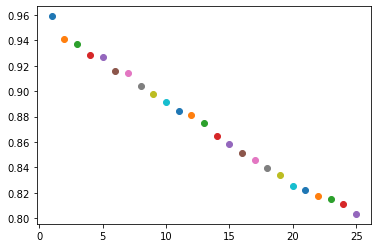

In [12]:
#KNN Grid Search
for k in range(25):
    KNN = KNeighborsClassifier(n_neighbors=k+1)
    KNNFitted = KNN.fit(X_train, y_train)
    knnTrainingAccuracy = KNNFitted.score(X_train,y_train)
    KnnTestedAccuracy = KNNFitted.score(X_test,y_test)
    print(k+1,': ',knnTrainingAccuracy,' ',KnnTestedAccuracy)
    plt.scatter(k+1,KnnTestedAccuracy)
plt.show()

In [13]:
#SVM Hyper Parameters
scaler = MinMaxScaler()
scaler.fit(X_train)
#SVM Grid Search
gammas = ['auto',1, 0.1, 0.01,.001]
kernals = ['poly', 'rbf', 'sigmoid']
cs = [250,500,750,1000,1500,2000,10000]
acc = 0 
for g in gammas:
    for kern in kernals:
        i = 1
        for c in cs:
            SVM = SVC(kernel = kern, C=c, gamma = g, decision_function_shape='ovr')
            SVMFitted = SVM.fit(scaler.transform(X_train), y_train)
            SVMTestedAccuracy = SVMFitted.score(scaler.transform(X_test),y_test)
            print(g,' ',kern,' ',c,': ',SVMTrainingAccuracy,' ',SVMTestedAccuracy)
            #plt.scatter(i,SVMTestedAccuracy)
            i = i + 1
            if SVMTestedAccuracy > acc:
                acc = SVMTestedAccuracy
                new = [g,' ',kern,' ',c,': ',SVMTrainingAccuracy,' ',SVMTestedAccuracy]
        print(new)
plt.show() 


auto   poly   250 :  0.9223880597014925   0.568013468013468
auto   poly   500 :  0.9223880597014925   0.6043771043771043
auto   poly   750 :  0.9223880597014925   0.6158249158249158
auto   poly   1000 :  0.9223880597014925   0.6255892255892256
auto   poly   1500 :  0.9223880597014925   0.6356902356902356
auto   poly   2000 :  0.9223880597014925   0.6484848484848484
auto   poly   10000 :  0.9223880597014925   0.6922558922558922
['auto', ' ', 'poly', ' ', 10000, ': ', 0.9223880597014925, ' ', 0.6922558922558922]
auto   rbf   250 :  0.9223880597014925   0.6892255892255892
auto   rbf   500 :  0.9223880597014925   0.7070707070707071
auto   rbf   750 :  0.9223880597014925   0.7151515151515152
auto   rbf   1000 :  0.9223880597014925   0.725925925925926
auto   rbf   1500 :  0.9223880597014925   0.7387205387205387
auto   rbf   2000 :  0.9223880597014925   0.7457912457912458
auto   rbf   10000 :  0.9223880597014925   0.7781144781144781
['auto', ' ', 'rbf', ' ', 10000, ': ', 0.9223880597014925, '

In [14]:
#Random Forest

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
RF = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = RF, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2,
                               random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_estimator_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomForestClassifier(max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=1757)

### Understanding incorrectly classified images

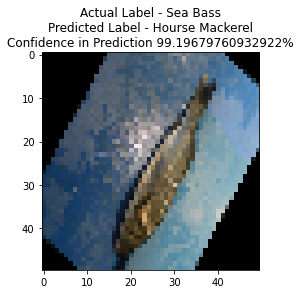

In [15]:
#Incorrect CNN Classifications
fishnumber = 6

IncorrectActualLabel = []
IncorrectPredictedLabel = []
CNNX_Incorrect = []
for i in range(len(CNNY_test_label)):
    if CNNY_test_label[i] != CNNyhat[i]:
        IncorrectActualLabel.append(CNNyhat[i])
        IncorrectPredictedLabel.append(CNNY_test_label[i])
        CNNX_Incorrect.append(CNNX_test[i])
CNNX_Incorrect = np.array(CNNX_Incorrect)
CNNX_Incorrect.astype('int')
plt.imshow(CNNX_Incorrect[fishnumber])
plt.title('Actual Label - '+str(FishCategories[np.array(IncorrectPredictedLabel)[fishnumber]])+'\n'+
          'Predicted Label - '+str(FishCategories[np.array(IncorrectActualLabel)[fishnumber]])+'\n'+
          'Confidence in Prediction ' +str(max(PredictedPercent[i]).astype('float')*100)+'%')    
plt.show()